<a href="https://colab.research.google.com/github/Anik85/Anik85/blob/main/CNN_model_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d erhmrai/ecg-image-data

ecg-image-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('/content/ecg-image-data.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import os, shutil
import warnings
warnings.filterwarnings('ignore')

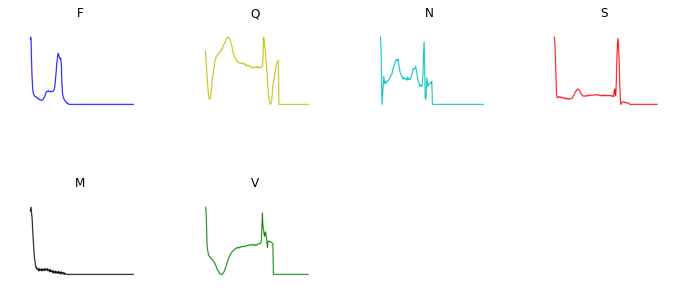

In [ ]:
from tensorflow.keras.preprocessing import image
train_path = "/content/ECG_Image_data/train"
test_path = "/content/ECG_Image_data/test"

image_categories = os.listdir('/content/ECG_Image_data/train')

def plot_images(image_categories):
    
    # Create a figure
    plt.figure(figsize=(12, 12))
    for i, image in enumerate(image_categories):
        
        # Load images for the ith category
        image_path = train_path + '/' + image
        images_in_folder = os.listdir(image_path)
        first_image_of_folder = images_in_folder[0]
        first_image_path = image_path + '/' + first_image_of_folder
        img = image.load_img(first_image_path)
        img_arr = image.img_to_array(img)/255.0
        
        
        # Create Subplot and plot the images
        plt.subplot(4, 4, i+1)
        plt.imshow(img_arr)
        plt.title(cat)
        plt.axis('off')
        
    plt.show()
plot_images(image_categories)

In [ ]:
train_gen = ImageDataGenerator(rescale = 1.0/255.0,
                               validation_split=0.2) # Normalise the data
train_image_generator = train_gen.flow_from_directory(
                                            train_path,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            subset='training',
                                            class_mode='categorical')

val_image_generator = train_gen.flow_from_directory(
                                            train_path,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            subset='validation',
                                            class_mode='categorical')

# 3. Test Set
test_gen = ImageDataGenerator(rescale = 1.0/255.0) # Normalise the data
test_image_generator = test_gen.flow_from_directory(
                                            test_path,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical')

Found 79362 images belonging to 6 classes.
Found 19837 images belonging to 6 classes.
Found 24799 images belonging to 6 classes.


In [ ]:
class_map = dict([(v, k) for k, v in train_image_generator.class_indices.items()])
print(class_map)

{0: 'F', 1: 'M', 2: 'N', 3: 'Q', 4: 'S', 5: 'V'}


In [ ]:
model = Sequential() # model object

# Add Layers
model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=[150, 150, 3]))
model.add(MaxPooling2D(2, ))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2))

# Flatten the feature map
model.add(Flatten())

# Add the fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='softmax'))

# print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 87616)             0         
                                                                 
 dense (Dense)               (None, 128)               1

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=5) # Set up callbacks
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics='accuracy')
hist = model.fit(train_image_generator, 
                 epochs=10, 
                 verbose=1, 
                 validation_data=val_image_generator,
                 steps_per_epoch = 15000//32, 
                 validation_steps = 3000//32, 
                 callbacks=early_stopping)

Epoch 1/10
468/468 [==============================] - 61s 115ms/step - loss: 0.1029 - accuracy: 0.9709 - val_loss: 0.0028 - val_accuracy: 0.9997
Epoch 2/10
468/468 [==============================] - 48s 103ms/step - loss: 0.0026 - accuracy: 0.9995 - val_loss: 2.7097e-04 - val_accuracy: 1.0000
Epoch 3/10
468/468 [==============================] - 49s 105ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 1.1189e-06 - val_accuracy: 1.0000
Epoch 4/10
468/468 [==============================] - 50s 106ms/step - loss: 2.3933e-04 - accuracy: 0.9999 - val_loss: 1.2521e-05 - val_accuracy: 1.0000
Epoch 5/10
468/468 [==============================] - 46s 99ms/step - loss: 0.0305 - accuracy: 0.9947 - val_loss: 0.0014 - val_accuracy: 0.9997
Epoch 6/10
468/468 [==============================] - 48s 103ms/step - loss: 0.0013 - accuracy: 0.9996 - val_loss: 5.2811e-07 - val_accuracy: 1.0000
Epoch 7/10
468/468 [==============================] - 47s 100ms/step - loss: 5.1789e-04 - accuracy: 0.9997 - va

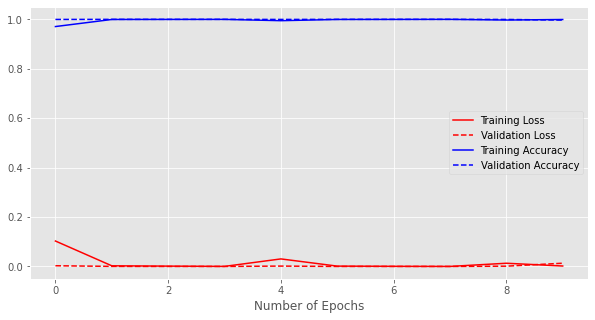

In [ ]:
h = hist.history
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(h['loss'], c='red', label='Training Loss')
plt.plot(h['val_loss'], c='red', linestyle='--', label='Validation Loss')
plt.plot(h['accuracy'], c='blue', label='Training Accuracy')
plt.plot(h['val_accuracy'], c='blue', linestyle='--', label='Validation Accuracy')
plt.xlabel("Number of Epochs")
plt.legend(loc='best')
plt.show()

Text(0, 0.5, 'accuracy')

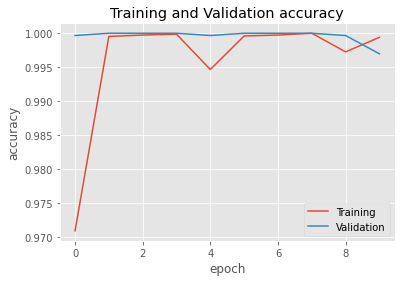

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [ ]:
results=model.evaluate(test_image_generator)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

775/775 [==============================] - 68s 87ms/step - loss: 0.0083 - accuracy: 0.9981
Test Loss: 0.00832
Test Accuracy: 99.81%


In [ ]:
y_pred = model.predict(test_image_generator)
y_pred

775/775 [==============================] - 63s 81ms/step


array([[1.5460606e-24, 0.0000000e+00, 1.0000000e+00, 5.7277656e-33,
        0.0000000e+00, 9.0870318e-37],
       [4.9044680e-27, 0.0000000e+00, 1.0000000e+00, 3.0825483e-35,
        0.0000000e+00, 0.0000000e+00],
       [8.3521048e-21, 0.0000000e+00, 1.0000000e+00, 2.8298371e-36,
        0.0000000e+00, 3.5552258e-35],
       ...,
       [3.9132058e-15, 1.0000000e+00, 0.0000000e+00, 2.3971825e-38,
        5.7954299e-28, 2.0398807e-21],
       [2.3387694e-22, 0.0000000e+00, 1.0000000e+00, 3.2914994e-34,
        0.0000000e+00, 4.9469509e-35],
       [3.8787710e-15, 1.0000000e+00, 5.7727390e-31, 2.8164511e-28,
        1.6902757e-21, 2.4023163e-17]], dtype=float32)

In [ ]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([2, 2, 2, ..., 1, 2, 1])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report


cm = confusion_matrix(np.argmax(test_image_generator), y_pred)
print(cm)
#print('classification report')
#print( classification_report(test_image_generator.classes, y_pred,labels=np.unique(test_image_generator.classes)))

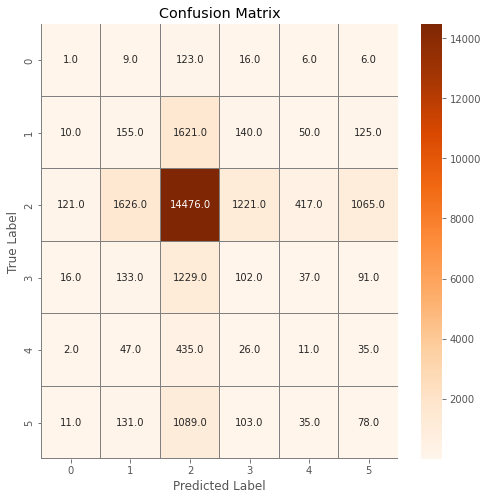

In [ ]:
import seaborn as sns
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Oranges",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

1/1 [==============================] - 0s 139ms/step


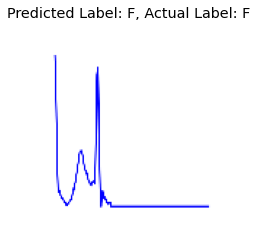

In [ ]:
from tensorflow.keras.preprocessing import image
test_image_path = '/content/ECG_Image_data/test/F/F796.png'

def generate_predictions(test_image_path, actual_label):
    
    # 1. Load and preprocess the image
    test_img = image.load_img(test_image_path, target_size=(150, 150))
    test_img_arr = image.img_to_array(test_img)/255.0
    test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0], test_img_arr.shape[1], test_img_arr.shape[2]))

    # 2. Make Predictions
    predicted_label = np.argmax(model.predict(test_img_input))
    predicted_vegetable = class_map[predicted_label]
    plt.figure(figsize=(4, 4))
    plt.imshow(test_img_arr)
    plt.title("Predicted Label: {}, Actual Label: {}".format(predicted_vegetable, actual_label))
    plt.grid()
    plt.axis('off')
    plt.show()

# call the function
generate_predictions(test_image_path, actual_label='F')